In [1]:
from nb_utils import rescale_plot, mtick, md, run_simulation,\
                     getSimulationData, get_pool_agent, get_arb_env,\
                     get_LT_LP_Binance_data, pd, plt, np, ASSET_PRICE_INDEX,\
                     datetime, get_binance_month_data, plot_impact_curves,\
                     runOneSimulation, getOneSimulationData, plot_one_sim_result

In [2]:
%load_ext autoreload
%autoreload 2

# Load data

In [3]:
LPdata      = pd.read_pickle("data/LPdata.pkl")
LTdata      = pd.read_pickle("data/LTdata.pkl")
BinanceData = pd.read_pickle("data/BinanceData.pkl")

#### Statistics

In [4]:
print('***** BINANCE *****')
print('Number of trades:', len(BinanceData))
print('Average txn size:', (BinanceData.price * BinanceData.qty).mean())
print('Total USD volume:', (BinanceData.price * BinanceData.qty).sum()/1e9)
print('Avg trading freq:', np.mean((np.diff(BinanceData.index)/1e9).astype(float)), 'seconds')

print('\n***** Uniswap (LT) *****')
print('Number of trades:', len(LTdata))
print('Average txn size:', LTdata.amountUSD.mean())
print('Total USD volume:', LTdata.amountUSD.sum()/1e9)
print('Avg trading freq:', np.mean((np.diff(LTdata.timestamp)/1e9).astype(float)), 'seconds')

print('\n***** Uniswap (LP) *****')
print('Number of trades:', len(LPdata))
print('Average txn size:', LPdata.amountUSD.abs().mean())
print('Total USD volume:', LPdata.amountUSD.abs().sum()/1e9)
print('Avg trading freq:', np.mean((np.diff(LPdata.timestamp)/1e9).astype(float)), 'seconds')

***** BINANCE *****
Number of trades: 12341854
Average txn size: 1735.279267307885
Total USD volume: 21.41656336634089
Avg trading freq: 2.560843659375946 seconds

***** Uniswap (LT) *****
Number of trades: 1701986
Average txn size: 109037.07921782526
Total USD volume: 185.57958230962956
Avg trading freq: 18.273118153215215 seconds

***** Uniswap (LP) *****
Number of trades: 42022
Average txn size: 2765499.211774799
Total USD volume: 116.21180787720061
Avg trading freq: 740.2948049784632 seconds


# CQV : Parameters

In [5]:
from_datetime = '2021-08-01 09:00'
to_datetime   = '2021-08-01 09:30'
trade_date    = '2021-08-01'

oneDayLTdata, oneDayLPdata, oneDaybinanceLTdata,\
fill_exponents, pool_sizes, hist_prices,\
initial_convexity, trade_sizes, bothPrices = get_LT_LP_Binance_data(LTdata, LPdata, BinanceData, trade_date, 
                                                                    from_datetime, to_datetime)
bothPrices.columns = ['Binance', 'Uniswap']

In [6]:
############################
# LP strategy parameters
############################
jump_size_L            = 0.1
phi                    = 1e-4
alpha                  = 1e-4
fill_exponent          = 2
initial_inventory_pool = 0 
arrival_rate           = 100 

############################
# Pool liquidity parameters
############################
initial_price          = 100
target_inventory       = initial_inventory_pool
min_inventory_pool     = initial_inventory_pool - 500.
max_inventory_pool     = initial_inventory_pool + 500.
unit_size              = 1

############################
# Others
############################
max_depth              = 0
terminal_time          = 30/60/24 #/24/ # 30 minutes
n_steps                = 20
step_size              = terminal_time/n_steps
seed                   = 1
num_trajectories       = 1
verbose                = False

# First test

In [7]:
############################
# Create agent
############################
def eta_func_bid(y, Delta, L):
    if y-Delta==0: return -L
    if y-Delta>0: return L * Delta  / (y - Delta)
    if y-Delta<0: return -L * Delta / (y - Delta)

def eta_func_ask(y, Delta, L):
    if y+Delta==0: return -L
    if y+Delta>0: return L * Delta  / (y + Delta)
    if y+Delta<0: return -L * Delta / (y + Delta)

pool_agent = get_pool_agent(arrival_rate, phi, alpha, fill_exponent, 
                            initial_inventory_pool, target_inventory, 
                            jump_size_L, unit_size, min_inventory_pool, max_inventory_pool,
                            initial_price, max_depth,
                            terminal_time, step_size,
                            seed, n_steps, num_trajectories, eta_func_bid, eta_func_ask,
                            verbose)

<AxesSubplot: >

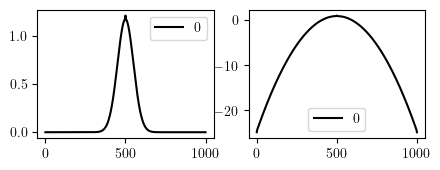

In [8]:
rescale_plot(W = 5, l = 9, w = 3, fontsize = 10)
fig, axes = plt.subplots(1, 2)
pd.DataFrame(pool_agent.omegas[2,:,:]).plot(ax=axes[0], color='k')
pd.DataFrame(pool_agent._calculate_ht(0.)).plot(ax=axes[1], color='k')

# Compare impact and cost curves 
### Scenario: same curves as uniswap

In [9]:
jump_size_L            = 0.2
phi                    = 1e-4
alpha                  = 1e-4
fill_exponent          = 2

pool_agent             = get_pool_agent(arrival_rate, phi, alpha, fill_exponent, 
                                        initial_inventory_pool, target_inventory, 
                                        jump_size_L, unit_size, min_inventory_pool, max_inventory_pool,
                                        initial_price, max_depth,
                                        terminal_time, step_size,
                                        seed, n_steps, num_trajectories, eta_func_bid, eta_func_ask,
                                        verbose)

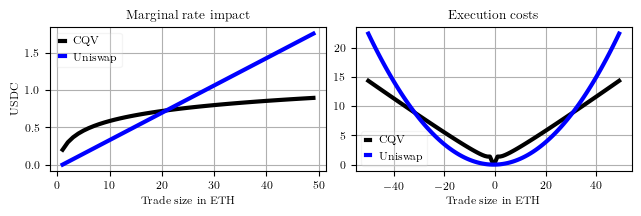

In [10]:
rescale_plot(W = 6.3,  l = 8, w = 2.6, fontsize = 8)

plot_impact_curves(pool_agent, 50, unit_size, 
                   jump_size_L, initial_convexity, initial_inventory_pool)

plt.savefig('plots/cqvuniswapexeccostsLoseMoney.pdf', bbox_inches='tight')
plt.show()

#### Simulate CQV arbitrage for this scenario

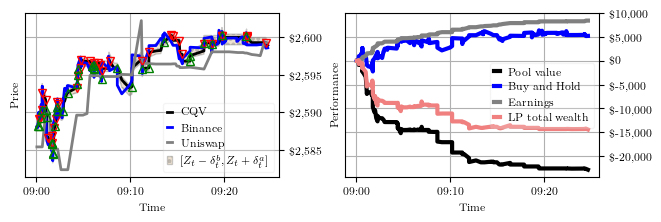

In [11]:
np.random.seed(42)

pool_earnings_history, arb_earnings_history, historical_pool_prices, historical_oracle_prices,\
historical_ba, historical_pool_inventory, historical_pool_cash, historical_pool_value_adjustments\
                    = runOneSimulation(pool_agent, bothPrices, unit_size, 
                                       min_inventory_pool, max_inventory_pool, target_inventory,
                                       eta_func_bid, eta_func_ask, jump_size_L, add_noise = 0)

initial_pool_value  = 0
allData_, bid_history, ask_history = getOneSimulationData(initial_pool_value, initial_inventory_pool,
                                                          historical_pool_prices,  historical_ba, 
                                                          historical_pool_inventory, pool_earnings_history, 
                                                          historical_oracle_prices, historical_pool_cash, 
                                                          historical_pool_value_adjustments)

# Clean simulation results
uniswapindex  = allData_.reset_index().dropna().index
allData       = allData_.dropna()
bid_history   = bid_history.loc[allData.index]
ask_history   = ask_history.loc[allData.index]
allData.index = bothPrices.iloc[uniswapindex].index

# Plot the result
rescale_plot(W = 6.5,  l = 8, w = 2.6, fontsize = 8)

plot_one_sim_result(allData, bothPrices, uniswapindex, bid_history, ask_history)

plt.savefig('plots/pathUniswapLoseMoney.pdf', bbox_inches='tight')
plt.show()

## Scenario: Strategic LP

In [12]:
jump_size_L            = 0.2
phi                    = 1e-4
alpha                  = 1e-4
fill_exponent          = 0.5

pool_agent             = get_pool_agent(arrival_rate, phi, alpha, fill_exponent, 
                                        initial_inventory_pool, target_inventory, 
                                        jump_size_L, unit_size, min_inventory_pool, max_inventory_pool,
                                        initial_price, max_depth,
                                        terminal_time, step_size,
                                        seed, n_steps, num_trajectories, eta_func_bid, eta_func_ask,
                                        verbose)

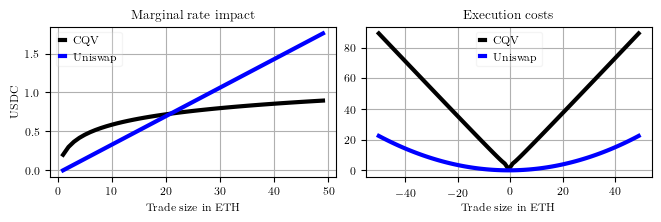

In [13]:
rescale_plot(W=5, l=8, w=3, fontsize=8)
rescale_plot(W = 6.5,  l = 8, w = 2.6, fontsize = 8)

plot_impact_curves(pool_agent, 50, unit_size, 
                   jump_size_L, initial_convexity, initial_inventory_pool)

plt.savefig('plots/cqvuniswapexeccostsEearnMoney.pdf', bbox_inches='tight')
plt.show()

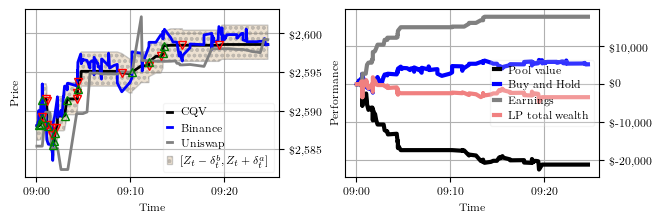

In [14]:
np.random.seed(42)

pool_earnings_history, arb_earnings_history, historical_pool_prices, historical_oracle_prices,\
historical_ba, historical_pool_inventory, historical_pool_cash, historical_pool_value_adjustments\
                    = runOneSimulation(pool_agent, bothPrices, unit_size, 
                                       min_inventory_pool, max_inventory_pool, target_inventory,
                                       eta_func_bid, eta_func_ask, jump_size_L, 0)

initial_pool_value  = 0
allData_, bid_history, ask_history = getOneSimulationData(initial_pool_value, initial_inventory_pool,
                                                          historical_pool_prices,  historical_ba, 
                                                          historical_pool_inventory, pool_earnings_history, 
                                                          historical_oracle_prices, historical_pool_cash, 
                                                          historical_pool_value_adjustments)

# Clean simulation results
uniswapindex  = allData_.reset_index().dropna().index
allData       = allData_.dropna()
bid_history   = bid_history.loc[allData.index]
ask_history   = ask_history.loc[allData.index]
allData.index = bothPrices.iloc[uniswapindex].index

# Plot the result
rescale_plot(W = 6.5,  l = 8, w = 2.6, fontsize = 8)

plot_one_sim_result(allData, bothPrices, uniswapindex, bid_history, ask_history)

plt.savefig('plots/pathUniswapStrategic.pdf', bbox_inches='tight')
plt.show()

#### Delta as a function of inventory

In [15]:
all_deltas_ = np.empty((len(pool_agent.inventory_space), 2))

for (i, inv) in enumerate(pool_agent.inventory_space):
    all_deltas_[i,:] = np.round(pool_agent._calculate_deltas(current_time = 0., 
                                inventories  = inv), 3)[0]

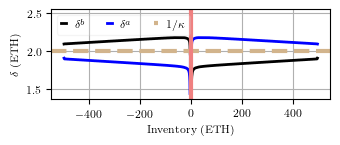

In [16]:
rescale_plot(W = 3.5, l = 7, w = 3, fontsize = 8)

plt.plot(pool_agent.inventory_space[4:-4], all_deltas_[4:-4, 0], color='k', lw= 2)
plt.plot(pool_agent.inventory_space[4:-4], all_deltas_[4:-4, 1], color='b', lw= 2)

#
plt.axhline(1/fill_exponent, color='tan', lw=3, linestyle='--')
plt.axvline(initial_inventory_pool, color='lightcoral', lw=3, linestyle='-')

plt.xlabel('Inventory (ETH)')
plt.ylabel(r'$\delta$ (ETH)')
plt.legend([r'$\delta^b$', r'$\delta^a$',  r'$1/\kappa$'], fancybox=True, framealpha=0.2, handlelength=0.4, ncol=3, loc='upper left')
plt.grid()
plt.tight_layout()
plt.savefig('plots/cqvuniswapprices.pdf', bbox_inches='tight')
plt.show()

# CQV Model study

In [17]:
compute_quotes    = False
n_steps           = 10
unit_size         = 1

initial_inventory_pool = 0
target_inventory       = initial_inventory_pool
min_inventory_pool     = initial_inventory_pool - 100
max_inventory_pool     = initial_inventory_pool + 100

L_values             = np.linspace(0,  0.2, 11)
phi_values           = np.linspace(0,  0.4, 5)
fill_exponent_values = np.linspace(0.5,  20,  6)
arrival_rate_values  = (0.2, 5, 10, 50, )
space_time           = np.linspace(0, terminal_time, n_steps)

if compute_quotes:    
    all_deltas = np.empty( (len(L_values), len(phi_values), len(fill_exponent_values), 
                            len(arrival_rate_values), len(space_time), 
                            (max_inventory_pool-min_inventory_pool)//unit_size+1 , 2)) #len(unt_size_values),  
    
    for (iL, jump_size_L) in enumerate(L_values):
        for (iphi, phi) in enumerate(phi_values):
            for (ifill, fill_exponent) in enumerate(fill_exponent_values):
                print('L =', jump_size_L, 'phi =', phi, 'fill_exponent=', fill_exponent)
                for (iAR, arrival_rate) in enumerate(arrival_rate_values):                    
                    pool_agent = get_pool_agent(arrival_rate, phi, alpha, fill_exponent, 
                                            initial_inventory_pool, target_inventory, 
                                            jump_size_L, unit_size, min_inventory_pool, max_inventory_pool,
                                            initial_price, max_depth,
                                            terminal_time, step_size,
                                            seed, n_steps, num_trajectories, eta_func_bid, eta_func_ask,
                                            verbose)
                    
                    for (i, inv) in enumerate(pool_agent.inventory_space):
                        for (j, t) in enumerate(space_time):
                            all_deltas[iL, iphi, ifill, iAR, j, i, :] = pool_agent._calculate_deltas(current_time = t, inventories  = inv)[0]
                            #all_deltas[iL, iphi, ifill, iAR, j, i, :, 1] = pool_agent._calculate_deltas(current_time = t, inventories  = inv)[1]
                            
    np.save('quotes.npy', all_deltas)
    space_var = pool_agent.inventory_space[2:-2]
else:
    space_var  = np.arange(-100, 101, unit_size)[2:-2]
    all_deltas = np.load('quotes.npy')

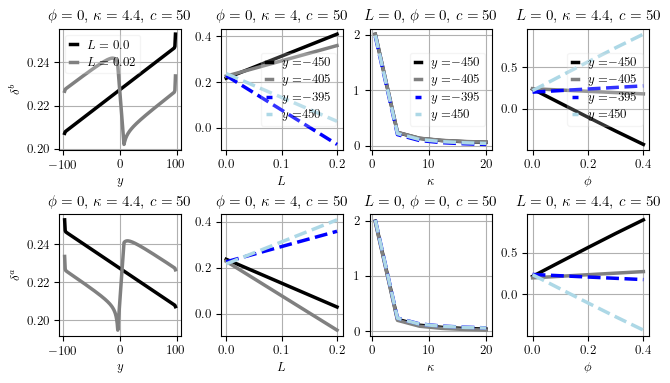

In [18]:
space_var  = np.arange(-100, 101, unit_size)[2:-2]
all_deltas = np.load('quotes.npy')
    
rescale_plot(W = 6.5, l = 7, w = 4, fontsize = 9)
fig, axes = plt.subplots(2, 4, sharey=False, constrained_layout=True)

iinv1, iinv2, iinv3, iinv4 = 200, 248, 252, 300
iinv1, iinv2, iinv3, iinv4 = 50, 95, 105, -51
iL, iphi, ifill, iAR       = 1, 0, 1, -1

##########################################################################################
##########################################################################################
# Quotes as a function of inventory
##########################################################################################
##########################################################################################
bids1, bids2 = all_deltas[0, iphi, ifill, iAR, 0, 2:-2, 0],\
                             all_deltas[1, iphi, ifill, iAR, 0, 2:-2, 0]
asks1, asks2 = all_deltas[0, iphi, ifill, iAR, 0, 2:-2, 1],\
                             all_deltas[1, iphi, ifill, iAR, 0, 2:-2, 1]

bids1 = np.concatenate( (bids1[:95], bids1[105:])); bids2 = np.concatenate( (bids2[:95], bids2[105:]))
asks1 = np.concatenate( (asks1[:95], asks1[105:])); asks2 = np.concatenate( (asks2[:95], asks2[105:]))

i_ax      = 0
space_var = np.concatenate( (space_var[:95], space_var[105:]))
varname   = r'$y$'
for (bids, asks, clr, ls) in zip((bids1, bids2), (asks1, asks2), ('k', 'gray', 'b', 'lightblue'), ('-', '-', '--', '--')):
    axes[0, i_ax].plot(space_var,  bids, color=clr, lw=2.5, linestyle=ls)
    axes[1, i_ax].plot(space_var,  asks, color=clr, lw=2.5, linestyle=ls)

for ax in axes[:, i_ax]:
    ax.set_xlabel(varname); ax.grid()

axes[0, i_ax].set_title(f'$\phi = {round(phi_values[iphi])}$, $\kappa = {round(fill_exponent_values[ifill], 2)}$, $c = {round(arrival_rate_values[iAR], 2)}$')
axes[1, i_ax].set_title(f'$\phi = {round(phi_values[iphi])}$, $\kappa = {round(fill_exponent_values[ifill], 2)}$, $c = {round(arrival_rate_values[iAR], 2)}$')
axes[0, i_ax].legend([f'$L={round(L_values[0], 2)}$', f'$L={round(L_values[1], 2)}$'],
                fancybox=True, framealpha=0.2, handlelength=0.5, ncol=1, loc='best')

##########################################################################################
##########################################################################################
# Quotes as a function of L
##########################################################################################
##########################################################################################
bids1, bids2, bids3, bids4 = all_deltas[:, iphi, ifill, iAR, 0, iinv1, 0],\
                            all_deltas[:, iphi, ifill, iAR, 0, iinv2, 0],\
                            all_deltas[:, iphi, ifill, iAR, 0, iinv3, 0],\
                            all_deltas[:, iphi, ifill, iAR, 0, iinv4, 0]
asks1, asks2, asks3, asks4 = all_deltas[:, iphi, ifill, iAR, 0, iinv1, 1],\
                          all_deltas[:, iphi, ifill, iAR, 0, iinv2, 1],\
                          all_deltas[:, iphi, ifill, iAR, 0, iinv3, 1],\
                          all_deltas[:, iphi, ifill, iAR, 0, iinv4, 1]

i_ax      = 1
space_var = L_values
varname   = r'$L$'
for (bids, asks, clr, ls) in zip((bids1, bids2, bids3, bids4), (asks1, asks2, asks3, asks4), ('k', 'gray', 'b', 'lightblue'), ('-', '-', '--', '--')):
    axes[0, i_ax].plot(space_var, bids, color=clr,        lw=2.5, linestyle=ls)
    axes[1, i_ax].plot(space_var,  asks, color=clr, lw=2.5, linestyle=ls)

for ax in axes[:, i_ax]:
    ax.set_xlabel(varname); ax.grid()

axes[0, i_ax].set_title(f'$L = {round(L_values[iL], 0)}$, $\phi = {round(phi_values[iphi], 2)}$, $\kappa = {round(fill_exponent_values[ifill], 2)}, $c = {round(arrival_rate_values[iAR], 2)}')
axes[0, i_ax].set_title(f'$\phi = {round(phi_values[iphi])}$, $\kappa = {round(fill_exponent_values[ifill])}$, $c = {round(arrival_rate_values[iAR], 0)}$')
axes[1, i_ax].set_title(f'$\phi = {round(phi_values[iphi])}$, $\kappa = {round(fill_exponent_values[ifill])}$, $c = {round(arrival_rate_values[iAR], 0)}$')



##########################################################################################
##########################################################################################
# Quotes as a function of kappa
##########################################################################################
##########################################################################################
bids1, bids2, bids3, bids4 = all_deltas[iL, iphi, :, iAR, 0, iinv1, 0],\
                             all_deltas[iL, iphi, :, iAR, 0, iinv2, 0],\
                             all_deltas[iL, iphi, :, iAR, 0, iinv3, 0],\
                             all_deltas[iL, iphi, :, iAR, 0, iinv4, 0]
asks1, asks2, asks3, asks4 = all_deltas[iL, iphi, :, iAR, 0, iinv1, 1],\
                             all_deltas[iL, iphi, :, iAR, 0, iinv2, 1],\
                             all_deltas[iL, iphi, :, iAR, 0, iinv3, 1],\
                             all_deltas[iL, iphi, :, iAR, 0, iinv4, 1]

i_ax      = 2
space_var = fill_exponent_values
varname   = r'$\kappa$'
for (bids, asks, clr, ls) in zip((bids1, bids2, bids3, bids4), (asks1, asks2, asks3, asks4), ('k', 'gray', 'b', 'lightblue'), ('-', '-', '--', '--')):
    axes[0, i_ax].plot(space_var, bids, color=clr,        lw=2.5, linestyle=ls)
    axes[1, i_ax].plot(space_var,  asks, color=clr, lw=2.5, linestyle=ls)

for ax in axes[:,i_ax]:
    ax.set_xlabel(varname); ax.grid()

axes[0, i_ax].set_title(f'$L = {round(L_values[iL], 0)}$, $\phi = {round(phi_values[iphi], 2)}$, $\kappa = {round(fill_exponent_values[ifill], 2)}, $c = {round(arrival_rate_values[iAR], 2)}')
axes[0, i_ax].set_title(f'$L = {round(L_values[iL])}$, $\phi = {round(phi_values[iphi])}$, $c = {round(arrival_rate_values[iAR], 0)}$')
axes[1, i_ax].set_title(f'$L = {round(L_values[iL])}$, $\phi = {round(phi_values[iphi])}$, $c = {round(arrival_rate_values[iAR], 0)}$')



##########################################################################################
##########################################################################################
# Quotes as a function of phi
##########################################################################################
##########################################################################################
bids1, bids2, bids3, bids4 = all_deltas[iL, :, ifill, iAR, 0, iinv1, 0],\
                             all_deltas[iL, :, ifill, iAR, 0, iinv2, 0],\
                             all_deltas[iL, :, ifill, iAR, 0, iinv3, 0],\
                             all_deltas[iL, :, ifill, iAR, 0, iinv4, 0]
asks1, asks2, asks3, asks4 = all_deltas[iL, :, ifill, iAR, 0, iinv1, 1],\
                             all_deltas[iL, :, ifill, iAR, 0, iinv2, 1],\
                             all_deltas[iL, :, ifill, iAR, 0, iinv3, 1],\
                             all_deltas[iL, :, ifill, iAR, 0, iinv4, 1]

i_ax      = 3
space_var = phi_values
varname   = r'$\phi$'
for (bids, asks, clr, ls) in zip((bids1, bids2, bids3, bids4), (asks1, asks2, asks3, asks4), ('k', 'gray', 'b', 'lightblue'), ('-', '-', '--', '--')):
    axes[0, i_ax].plot(space_var, bids, color=clr,        lw=2.5, linestyle=ls)
    axes[1, i_ax].plot(space_var,  asks, color=clr, lw=2.5, linestyle=ls)

for ax in axes[:, i_ax]:
    ax.set_xlabel(varname); ax.grid()

axes[0, i_ax].set_title(f'$L = {round(L_values[iL], 0)}$, $\phi = {round(phi_values[iphi], 2)}$, $\kappa = {round(fill_exponent_values[ifill], 2)}, $c = {round(arrival_rate_values[iAR], 2)}$')
axes[0, i_ax].set_title(f'$L = {round(L_values[iL])}$, $\kappa = {round(fill_exponent_values[ifill], 2)}$, $c = {round(arrival_rate_values[iAR], 2)}$')
axes[1, i_ax].set_title(f'$L = {round(L_values[iL])}$, $\kappa = {round(fill_exponent_values[ifill], 2)}$, $c = {round(arrival_rate_values[iAR], 2)}$')


# final touches
for i_ax in (1, 2, 3):
    axes[0, i_ax].legend([r"$y=$"+f'${round(pool_agent.inventory_space[iinv1])}$', 
                r"$y=$"+f'${round(pool_agent.inventory_space[iinv2])}$', 
                r"$y=$"+f'${round(pool_agent.inventory_space[iinv3])}$', 
                r"$y=$"+f'${round(pool_agent.inventory_space[iinv4])}$',],
                fancybox=True, framealpha=0.2, handlelength=0.5, ncol=1, loc='center right')

axes[0, 0].set_ylabel(r'$\delta^b$');
axes[1, 0].set_ylabel(r'$\delta^a$');

for i_ax in (0, 1, 2, 3):
    axes[0, i_ax].sharex(axes[1, i_ax])

plt.savefig('plots/cqvparams.pdf', bbox_inches='tight')
plt.show()